Импорт данных для обучения
[California Housing Prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices?resource=download)


In [57]:
# !pip install folium
# !pip install scikit-learn
# !pip install pandas
# !pip install numpy
# !pip install matplotlib

Импорты:

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [79]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "housing.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "camnugent/california-housing-prices",
  file_path)

print("First 5 records:", df.head())

/tmp/ipython-input-2580593292.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'california-housing-prices' dataset.
First 5 records:    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            34220



---



# ***Чистка***

Почистим датасет.
Начнем с пропусков

In [80]:
# сколько пропусков в каждом столбце
print(df.isnull().sum())

# общее количество пропусков
print("Всего пропусков:", df.isnull().sum().sum())


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64
Всего пропусков: 207


Нужно убрать пропуски total_bedrooms

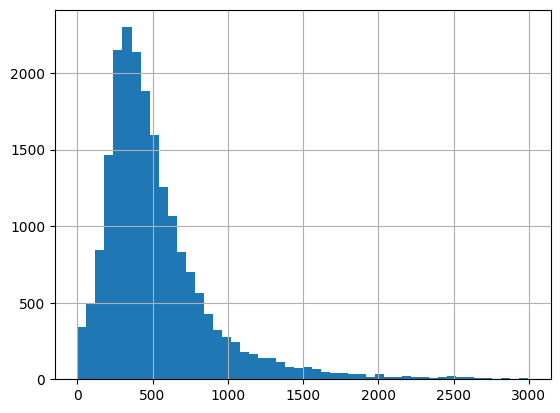

In [61]:
df[df["total_bedrooms"] < 3000]["total_bedrooms"].hist(bins=50)
plt.show()

In [62]:
print("Медиана:", df["total_bedrooms"].median())
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())

Медиана: 435.0


In [63]:
# сколько пропусков в каждом столбце
print(df.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


Построим графики по всем значениям признакам, чтобы проверить их на выбросы.

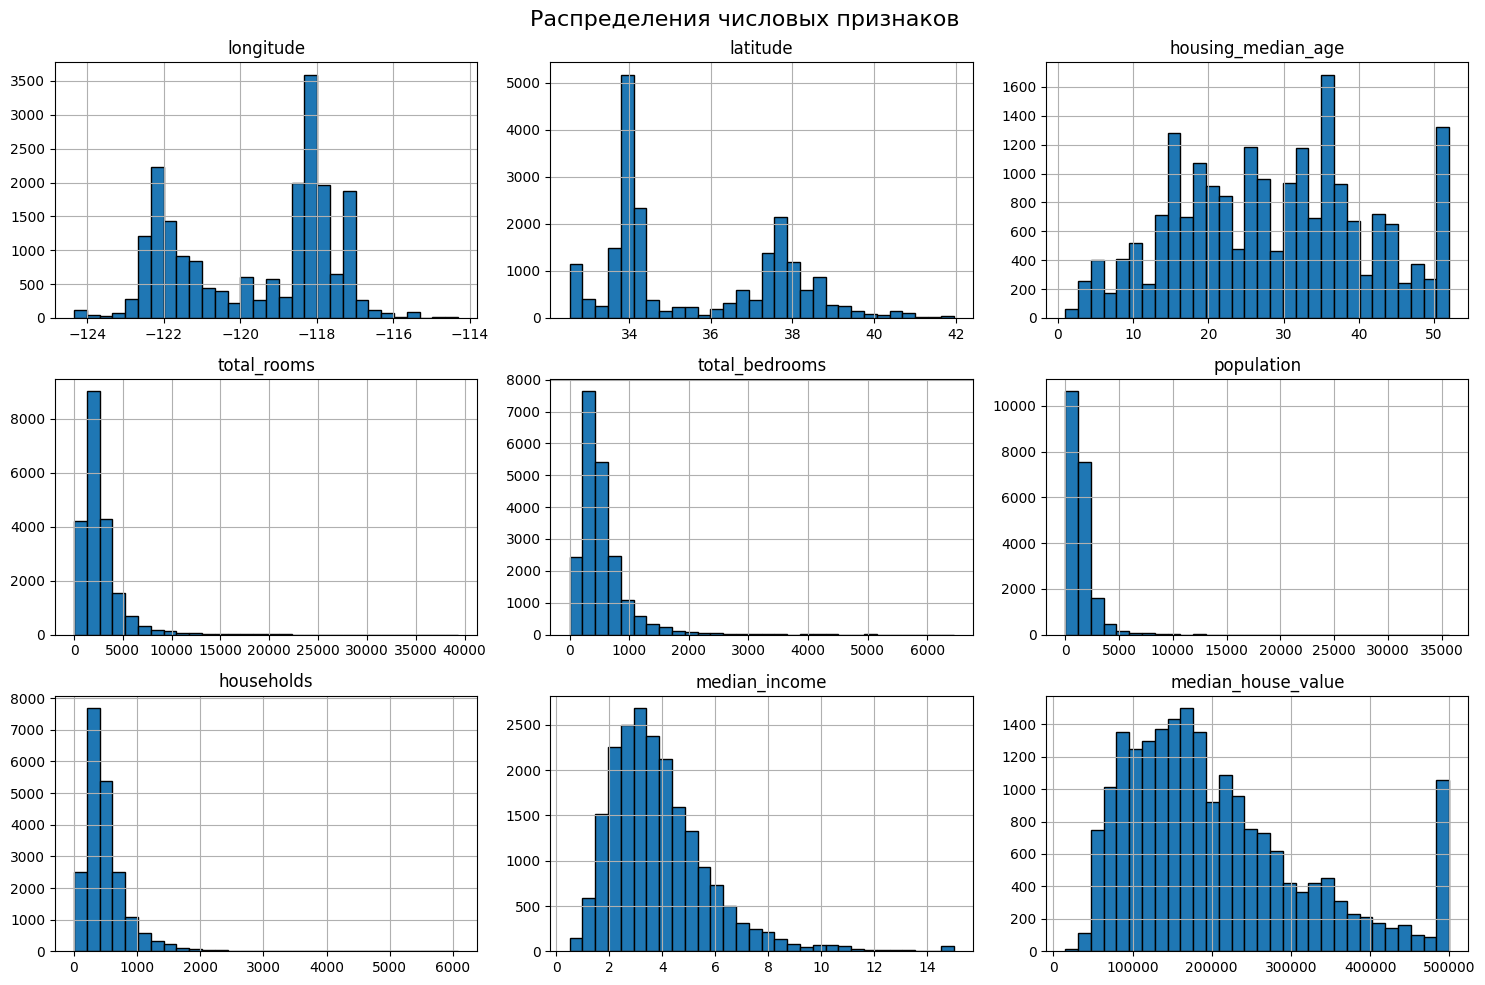

In [64]:
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.suptitle("Распределения числовых признаков", fontsize=16)
plt.tight_layout()
plt.show()

По диаграммам видно, что total_rooms, total_bedrooms, population, households имеют большие выбросы. Решение: логарифмировать или обрубать концы.

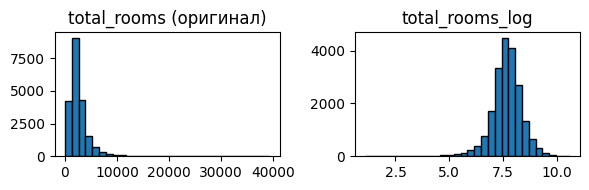

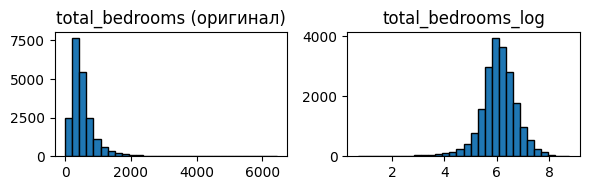

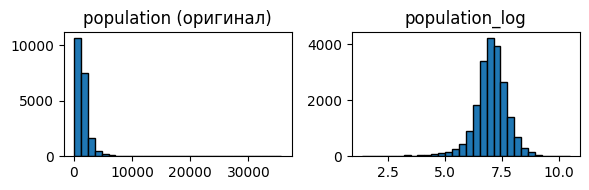

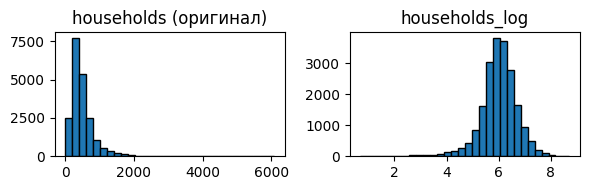

In [65]:
import numpy as np

cols_to_log = ["total_rooms", "total_bedrooms", "population", "households"]

for col in cols_to_log:
    df[col + "_log"] = np.log1p(df[col])

    fig, axes = plt.subplots(1, 2, figsize=(6, 2))

    axes[0].hist(df[col].dropna(), bins=30, edgecolor="black")
    axes[0].set_title(f"{col} (оригинал)")

    axes[1].hist(df[col + "_log"].dropna(), bins=30, edgecolor="black")
    axes[1].set_title(f"{col}_log")

    plt.tight_layout()
    plt.show()


In [66]:
df = df.drop(cols_to_log, axis=1)

"ocean_proximity" - признак, который нужно разбить на несколько признаков при помощи OneHotEncoding

In [67]:
df = pd.get_dummies(df, columns = ["ocean_proximity"], drop_first = True)

print(df.head())

   longitude  latitude  housing_median_age  median_income  median_house_value  \
0    -122.23     37.88                41.0         8.3252            452600.0   
1    -122.22     37.86                21.0         8.3014            358500.0   
2    -122.24     37.85                52.0         7.2574            352100.0   
3    -122.25     37.85                52.0         5.6431            341300.0   
4    -122.25     37.85                52.0         3.8462            342200.0   

   total_rooms_log  total_bedrooms_log  population_log  households_log  \
0         6.781058            4.867534        5.777652        4.844187   
1         8.867850            7.009409        7.784057        7.037906   
2         7.291656            5.252273        6.208590        5.181784   
3         7.150701            5.463832        6.326149        5.393628   
4         7.395108            5.638355        6.338594        5.560682   

   ocean_proximity_INLAND  ocean_proximity_ISLAND  ocean_proximity_N



---



# ***Добавление новых признаков на основе существующих***

Основную чистку провели, теперь можно поглядеть какие у нас отношения между признаками.

In [68]:
df["rooms_per_household_log"] = (df["total_rooms_log"] / df["households_log"])
df["bedrooms_per_room_log"] = (df["total_bedrooms_log"] / df["total_rooms_log"])
df["population_per_household_log"] = (df["population_log"] / df["households_log"])

**Объяснение новых признаков:**


1.   rooms_per_household — среднее количество комнат на одно домохозяйство.
Показывает «просторность жилья»: чем выше значение, тем больше комнат приходится на одну семью/группу жильцов.
2.   bedrooms_per_room — доля спален среди всех комнат.
Характеризует структуру жилья: если почти все комнаты — спальни, жильё обычно более простое и дешевое; низкая доля указывает на просторные и дорогие дома.
3.  population_per_household — среднее количество людей в одном домохозяйстве.
Отражает плотность проживания: большие значения = скученность и более дешёвое жильё, низкие значения = просторные условия и более высокая цена.



Страшная вещь - работаем с геолокацией.

In [69]:
# 1) Рёбра бинов: 20 ячеек = 21 граница
lat_edges = np.linspace(df["latitude"].min(),  df["latitude"].max(),  101)
lon_edges = np.linspace(df["longitude"].min(), df["longitude"].max(), 101)

# 2) Бинируем координаты в индексы 0..19
df["lat_bin"] = pd.cut(df["latitude"],  bins=lat_edges, labels=False, include_lowest=True)
df["lon_bin"] = pd.cut(df["longitude"], bins=lon_edges, labels=False, include_lowest=True)

# выкинем строки, где не попали в бин (NaN)
df2 = df.dropna(subset=["lat_bin", "lon_bin"]).copy()
df2["lat_bin"] = df2["lat_bin"].astype(int)
df2["lon_bin"] = df2["lon_bin"].astype(int)

# 3) Агрегация по ячейкам
grid = (df2.groupby(["lat_bin", "lon_bin"])["median_house_value"]
          .median()
          .reset_index())

# 4) Цветовая функция (зелёный -> красный)
min_val, max_val = df2["median_house_value"].min(), df2["median_house_value"].max()
def value_to_color(v):
    r = int(255 * (v - min_val) / (max_val - min_val))
    g = 255 - r
    return f'#{r:02x}{g:02x}00'

# 5) Карта и прямоугольники
m = folium.Map(location=[df2["latitude"].mean(), df2["longitude"].mean()], zoom_start=6)

for lat_bin, lon_bin, med in grid.itertuples(index=False):
    lat0 = lat_edges[lat_bin]
    lat1 = lat_edges[lat_bin + 1]
    lon0 = lon_edges[lon_bin]
    lon1 = lon_edges[lon_bin + 1]

    folium.Rectangle(
        bounds=[[lat0, lon0], [lat1, lon1]],
        fill=True, fill_opacity=0.6, color=None,
        fill_color=value_to_color(med),
        popup=f"Median: {med:.0f}"
    ).add_to(m)

m


In [70]:
# оставляем только выбросы
outliers = df[df["population_per_household_log"] > np.log1p(100)] # Apply log to 100 for comparison

# создаём карту (центрируем по средним координатам)
m = folium.Map(
    location=[df["latitude"].mean(), df["longitude"].mean()],
    zoom_start=6,
    tiles="cartodbpositron"
)

# добавляем точки
for _, row in outliers.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=0.8,
        popup=f"population_per_household_log: {row['population_per_household_log']:.2f}" # Display log value
    ).add_to(m)

m  # в Jupyter отобразится карта

### Выводы по тепловой карте цен жилья

- **Побережье дороже всего.** Красные квадраты сосредоточены вокруг Лос-Анджелеса, Сан-Диего и Сан-Франциско — это подтверждает ключевую роль близости к океану и крупным агломерациям.  

- **Центральная Калифорния остаётся дешёвой.** Внутренние районы (Фресно, Бейкерсфилд и др.) окрашены в зелёный: медианные цены жилья здесь заметно ниже.  

- **Резкий градиент «океан → глубина штата».** Стоимость жилья падает буквально в пределах десятков километров от побережья.  

- **Южная Калифорния дороже северной.** Район Лос-Анджелеса выделяется на карте как зона наиболее высоких цен, в то время как север штата (Реддинг, Чико) остаётся доступным.  


В целом тенденция понятна - ближе к пляжу - лучше, нет добавлять ещё признаки

Но мне нравится идея того, чтобы прологарифмировать стоимость жилья и сравнить графики

In [71]:
df["median_house_value_log"] = np.log1p(df["median_house_value"])
df["median_house_value_log"]

,median_house_value_log
0,13.022766
1,12.789687
2,12.771673
3,12.740520
4,12.743154
...,...
20635,11.265758
20636,11.252872
20637,11.432810
20638,11.346883


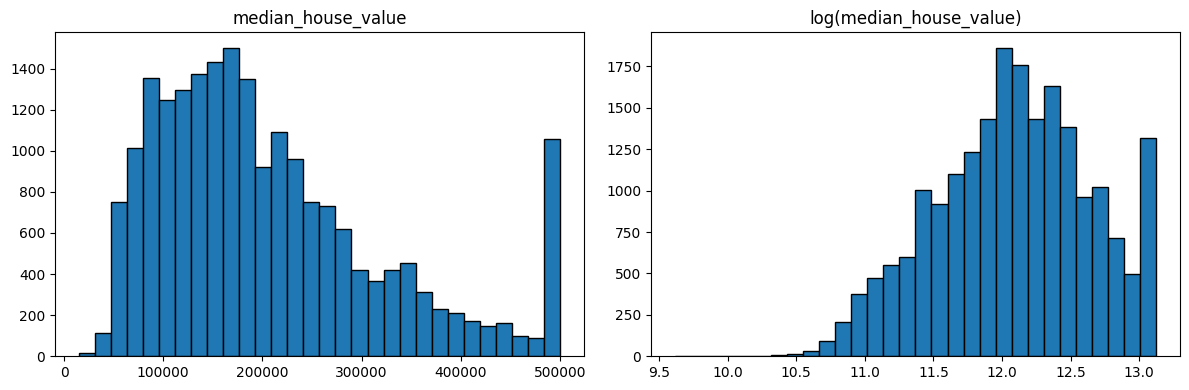

In [72]:
house_value = df["median_house_value"]
house_value_log = np.log1p(house_value)  # log(1+x)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# обычное распределение
axes[0].hist(house_value, bins=30, edgecolor="black")
axes[0].set_title("median_house_value")

# логарифмированное распределение
axes[1].hist(house_value_log, bins=30, edgecolor="black")
axes[1].set_title("log(median_house_value)")

df = df.drop("median_house_value", axis = 1)

plt.tight_layout()
plt.show()

# StandardScaler:

In [73]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

X = df.drop("median_house_value_log", axis=1)  # признаки
y = df["median_house_value_log"]               # целевая переменная

scaler = StandardScaler()
X_sscaled = scaler.fit_transform(X)

X_sscaled = pd.DataFrame(X_sscaled, columns=X.columns)

X_sscaled.head()

,longitude,latitude,housing_median_age,median_income,total_rooms_log,total_bedrooms_log,population_log,households_log,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,rooms_per_household_log,bedrooms_per_room_log,population_per_household_log,lat_bin,lon_bin
0,-1.327835,1.052548,0.982143,2.344766,-1.131133,-1.642192,-1.694943,-1.569395,-0.681889,-0.015566,2.830742,-0.384466,1.509871,-1.985369,0.192015,1.04095,-1.308880
1,-1.322844,1.043185,-0.607019,2.332238,1.651357,1.320043,1.030337,1.449251,-0.681889,-0.015566,2.830742,-0.384466,-0.266995,-0.048207,-0.985206,1.04095,-1.308880
2,-1.332827,1.038503,1.856182,1.782699,-0.450310,-1.110094,-1.109604,-1.104849,-0.681889,-0.015566,2.830742,-0.384466,1.603113,-1.918694,0.266154,1.04095,-1.308880
3,-1.337818,1.038503,1.856182,0.932968,-0.638257,-0.817506,-0.949925,-0.813343,-0.681889,-0.015566,2.830742,-0.384466,0.568638,-0.750662,-0.076961,1.04095,-1.358991
4,-1.337818,1.038503,1.856182,-0.012881,-0.312370,-0.576140,-0.933021,-0.583469,-0.681889,-0.015566,2.830742,-0.384466,0.621044,-0.794770,-0.525120,1.04095,-1.358991


In [74]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'median_income',
       'total_rooms_log', 'total_bedrooms_log', 'population_log',
       'households_log', 'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'rooms_per_household_log', 'bedrooms_per_room_log',
       'population_per_household_log', 'lat_bin', 'lon_bin',
       'median_house_value_log'],
      dtype='object')

# MinMax Scaler

In [75]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Создаём скейлер и применяем
scaler = MinMaxScaler(feature_range=(0, 1))
X_mmscaled = X.copy()
X_mmscaled[num_cols] = scaler.fit_transform(X[num_cols])

# Проверим результат
print(X_mmscaled[num_cols].agg(['min','mean','max']).round(4).T.head())

# Если нужен итоговый DataFrame с целевой
df_scaled = pd.concat([X_mmscaled, y], axis=1)

                    min    mean  max
longitude           0.0  0.4761  1.0
latitude            0.0  0.3286  1.0
housing_median_age  0.0  0.5420  1.0
median_income       0.0  0.2325  1.0
total_rooms_log     0.0  0.6888  1.0


Заебись, теперь у нас есть версия отстандартскейленная и отминмаксскейленная версия. Но теперь нужно будет сравнить.

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   longitude                     20640 non-null  float64
 1   latitude                      20640 non-null  float64
 2   housing_median_age            20640 non-null  float64
 3   median_income                 20640 non-null  float64
 4   total_rooms_log               20640 non-null  float64
 5   total_bedrooms_log            20640 non-null  float64
 6   population_log                20640 non-null  float64
 7   households_log                20640 non-null  float64
 8   ocean_proximity_INLAND        20640 non-null  bool   
 9   ocean_proximity_ISLAND        20640 non-null  bool   
 10  ocean_proximity_NEAR BAY      20640 non-null  bool   
 11  ocean_proximity_NEAR OCEAN    20640 non-null  bool   
 12  rooms_per_household_log       20640 non-null  float64
 13  b

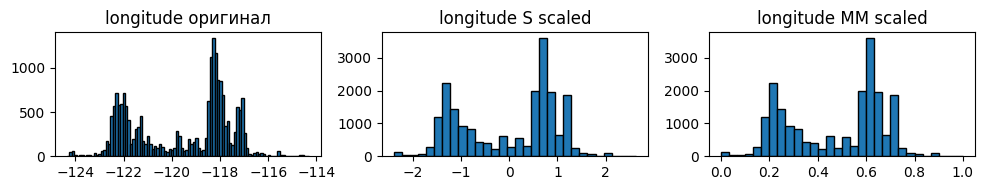

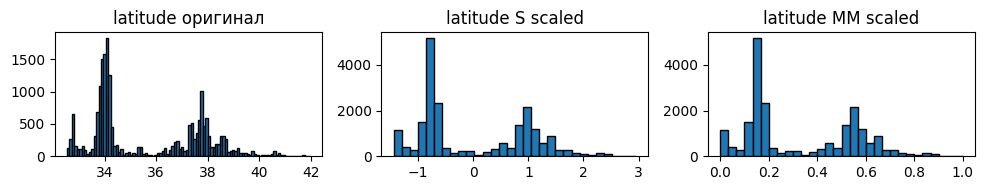

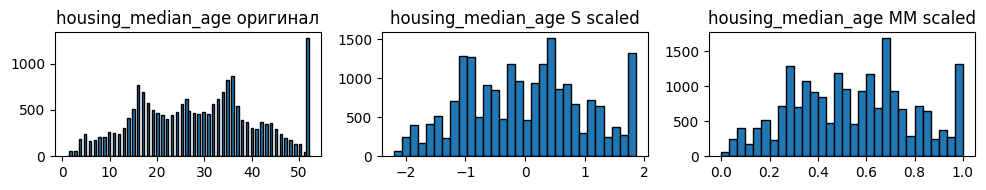

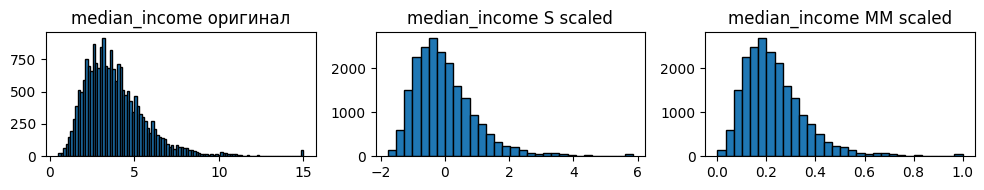

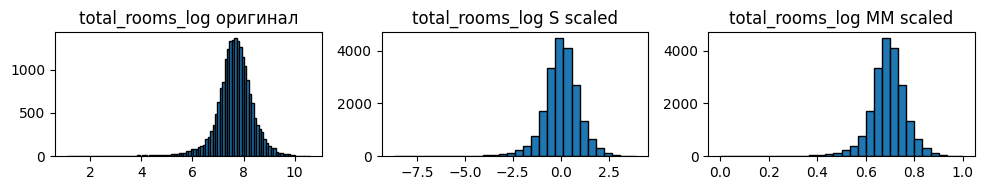

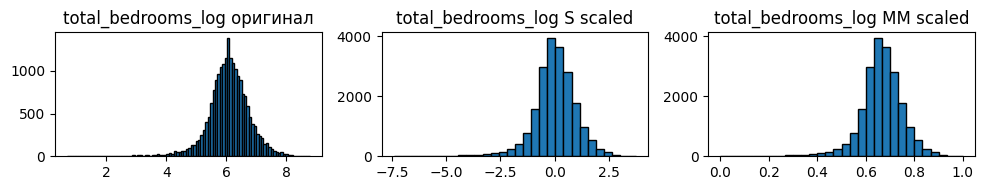

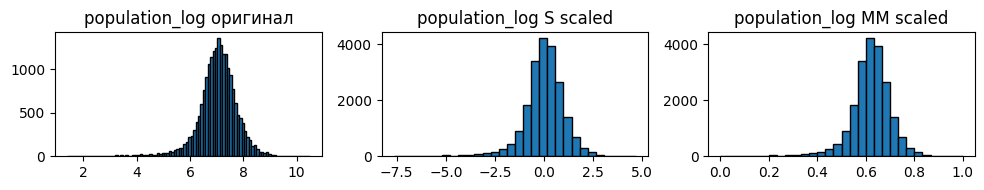

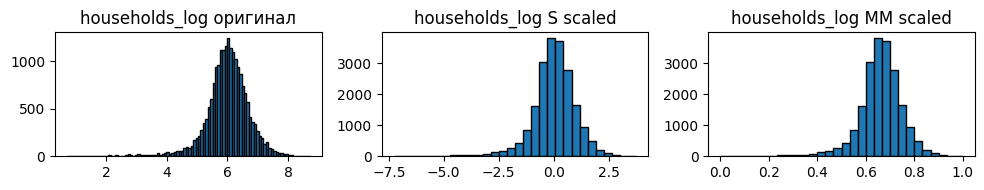

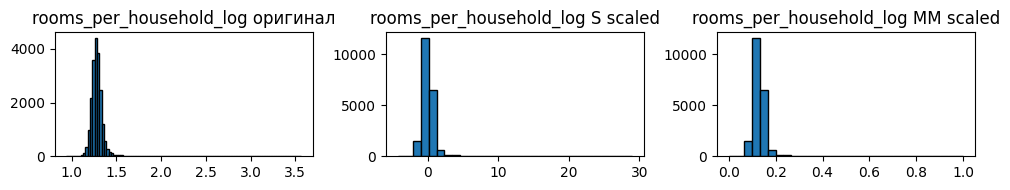

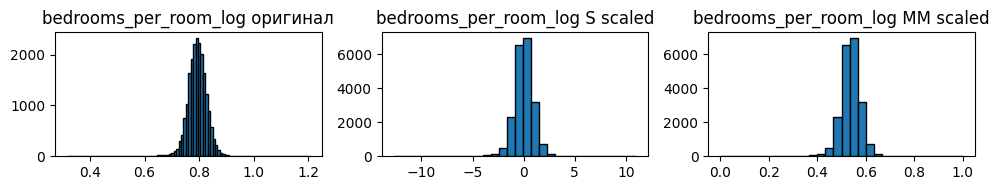

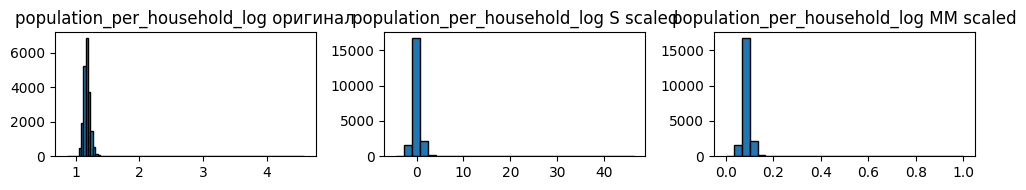

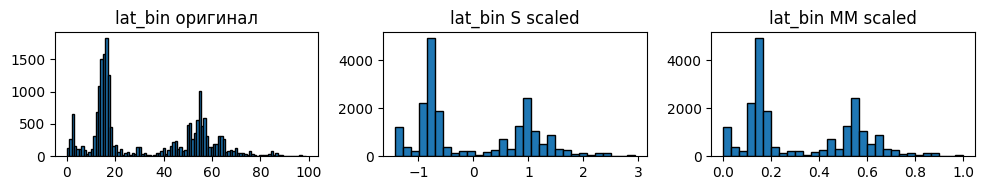

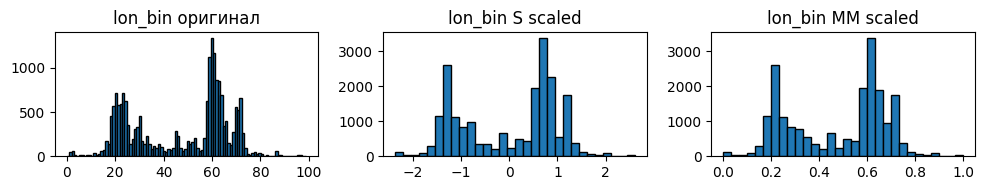

In [77]:
import numpy as np

cols_to_vs = df.select_dtypes(include="number").drop("median_house_value_log", axis=1).columns.tolist()
cols_to_vs

for col in cols_to_vs:
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))

    axes[0].hist(df[col].dropna(), bins=100, edgecolor="black")
    axes[0].set_title(f"{col} оригинал")

    axes[1].hist(X_sscaled[col].dropna(), bins=30, edgecolor="black")
    axes[1].set_title(f"{col} S scaled")

    axes[2].hist(X_mmscaled[col].dropna(), bins=30, edgecolor="black")
    axes[2].set_title(f"{col} MM scaled")

    plt.tight_layout()
    plt.show()



In [78]:
X = df.drop(columns=["median_house_value_log"])  # признаки
y = df["median_house_value_log"]                 # целевая переменная

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% на тест
    random_state=42,     # фиксируем случайность
    shuffle=True         # перемешиваем (по умолчанию True)
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (16512, 17) (16512,)
Test shape: (4128, 17) (4128,)
